In [5]:
#CNN Standalone Model

#Import Requirements
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Global variables for file paths
image_folder = "C:/Users/compsci6651/Desktop/Filtered_Images" #Images 
#txt path representing all images in the original dataset 
labels_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/HAM10000_metadata.txt'  
labels_dict = {}  # Initialize dictionary to hold image labels
#The dataset originally contains images in 7 different classes. This helps narrow it down to 2.
with open(labels_file_path, 'r', encoding='utf-8') as file:
    next(file)  # Skip the header row
    for line in file:
        parts = line.strip().split(',')
        image_id = parts[1]
        label = parts[2]
        if label in ['nv', 'mel']:
            labels_dict[image_id] = label

# CustomDataGenerator class inherits from keras.utils.Sequence ensuring efficient batch loading and optional augmentation
class CustomDataGenerator(keras.utils.Sequence):
    # Initialization method for the data generator
    def __init__(self, image_paths, labels, batch_size, image_size, augment):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment # Boolean to determine whether to augment data

        self.indexes = np.arange(len(self.image_paths))
        if self.augment:
            self.augmentor = ImageDataGenerator(
    rotation_range=20,       # Rotation range in degrees
    width_shift_range=0.2,   # Fraction of total width for horizontal shift
    height_shift_range=0.2,  # Fraction of total height for vertical shift
    zoom_range=0.2,          # Zoom range
    fill_mode='reflect')     # Use 'reflect' mode for filling gaps after a shift)
        else:
            self.augmentor = ImageDataGenerator(rescale=1. / 255)

    # Returns the number of batches per epoch
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    # Generate one batch of data
    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_paths))

        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        X = np.zeros((len(batch_paths), *self.image_size, 3)) # Initialize array for images
        y = np.zeros(len(batch_paths))  # Initialize array for labels

        for i, path in enumerate(batch_paths):
            # Load and preprocess the image by converting to RGB if not and normalizing it
            image = Image.open(path).convert('RGB')
            image = image.resize(self.image_size[::-1]) #Original images were broadcasted with shape (120, 90, 3) So this fixed the issue
            image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize
            if self.augment:
                image_array = self.augmentor.random_transform(image_array) #Randomly applies transformations

            X[i] = image_array
            y[i] = batch_labels[i]

        return X, y

#Helps assign the two labels into integers
label_to_int = {'nv': 0, 'mel': 1}
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if
               filename.endswith('.jpg')]
image_labels = [label_to_int[labels_dict.get(filename.replace('.jpg', ''), "unknown")] for filename in
                os.listdir(image_folder) if filename.endswith('.jpg')]


#Images were resampled and kept in a separate folder to keep track of oversampled images
augmented_folder = 'C:/Users/compsci6651/Desktop/augmented_images'
augmented_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/Augmented'

augmented_paths = [os.path.join(augmented_folder, filename) for filename in os.listdir(augmented_folder) if
                   filename.endswith('.jpg')]
augmented_labels = [label_to_int['mel'] for _ in range(len(augmented_paths))]


# Combine the original data and the oversampled data

total_image_paths = []
total_image_paths.extend(image_paths)
total_image_paths.extend(augmented_paths)

total_image_labels = []
total_image_labels.extend(image_labels)
total_image_labels.extend(augmented_labels)

# Combine image paths and labels into a single list of tuples
combined = list(zip(total_image_paths, total_image_labels))

# Shuffle the combined list
np.random.shuffle(combined)

# Unzip the shuffled combined list back into image paths and labels
total_image_paths, total_image_labels = zip(*combined)

# Convert back to lists
total_image_paths = list(total_image_paths)
total_image_labels = list(total_image_labels)

#Split data
X_temp, X_test_paths, y_temp, y_test = train_test_split(total_image_paths, total_image_labels, test_size=0.2,
                                                        stratify=total_image_labels, random_state=42)
X_train_paths, X_validate_paths, y_train, y_validate = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp,
                                                                        random_state=42)

# Initialize the classifier neural network to classify between two things
batch_size = 32
train_generator = CustomDataGenerator(X_train_paths, y_train, batch_size, (120, 90), augment = True)
validate_generator = CustomDataGenerator(X_validate_paths, y_validate, batch_size, (120, 90), augment = False)


# Model Structure Built

classifier = Sequential()
learning_rate = 0.0001 #learning rate
optimus = Adam(learning_rate=learning_rate) #import Adam with the learning rate adjusted

# Step 1: Global Patterns
classifier.add(Conv2D(64, (3, 3), input_shape=(90, 120, 3), activation='relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Step 2: Local Features
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
classifier.add(Flatten())
classifier.add(Dense(units=384))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dense(units=32))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dense(units=32))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))


classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer=optimus, loss='binary_crossentropy', metrics=['accuracy'])
#Checking up model structure
classifier.summary()

# Fitting the model using custom data generators

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = classifier.fit(train_generator, epochs=10, validation_data=validate_generator, callbacks=[early_stopping])
test_generator = CustomDataGenerator(X_test_paths, y_test, batch_size, (120, 90), False)
test_loss, test_accuracy = classifier.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

threshold = 0.7 #setting threshold to 70% minimum
y_pred_probs = classifier.predict(test_generator)
y_pred_class = (y_pred_probs > threshold).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, and F1 Score using y_pred_class
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extracting True Positives, False Positives, False Negatives, True Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (True Positive Rate) and Specificity (True Negative Rate)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# ROC Curve and AUC using y_pred_probs (continuous probabilities)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision0, recall0, thresholds = precision_recall_curve(y_test, y_pred_probs)
auc_pr = auc(recall0, precision0)

Original labels: [0, 0, 0, 0, 1]
Augmented labels: [1, 1, 1, 1, 1]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 88, 118, 64)       1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 86, 116, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 43, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 56, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 39, 54, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 27, 128)    

In [6]:
# CNN + Feature Extraction

import cv2
from PIL import Image
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, \
    confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Function to compute Hu moments which are a set of 7 numbers calculated from image moments and are invariant to image transformations
def compute_hu_moments(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.HuMoments(cv2.moments(gray)).flatten()
    return moments

# Function to compute color histogram for each color channel in an image, which captures the color distribution of the image
def compute_color_histogram(image_path):
    image = cv2.imread(image_path)
    hist_colors = []
    for i in range(3):  # For each color channel
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        hist_colors.extend(hist.flatten())
    return np.array(hist_colors)

# Function to combine Hu moments and color histogram into a single feature vector for an image
# Later used in CustomDataGenerator
def combine_hu_colors(image_path):
    hu_moments = compute_hu_moments(image_path)
    color_histogram = compute_color_histogram(image_path)
    return np.concatenate([hu_moments, color_histogram])

# CustomDataGenerator class inherits from keras.utils.Sequence ensuring efficient batch loading and optional augmentation
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, augment):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_paths))
        self.augment = augment

        if self.augment:
            self.augmentor = ImageDataGenerator(
    rotation_range=20,       # Rotation range in degrees
    width_shift_range=0.2,   # Fraction of total width for horizontal shift
    height_shift_range=0.2,  # Fraction of total height for vertical shift
    zoom_range=0.2,          # Zoom range
    fill_mode='reflect')     # Use 'reflect' mode for filling gaps after a shift)

    # Method to compute the number of batches per epoch
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_paths))

        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]
        
        # Preallocate arrays for images and features
        X_images = np.zeros((len(batch_paths), *self.image_size, 3))
        X_features = np.zeros((len(batch_paths), feature_length))  # Adjust the size to match your feature length

        for i, path in enumerate(batch_paths):
            # Load and preprocess the image
            image = Image.open(path).convert('RGB')
            image = image.resize(self.image_size[::-1])
            image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize
            if self.augment:
                image_array = self.augmentor.random_transform(image_array)

            # Extract Hu moments and color histograms
            additional_features = combine_hu_colors(path)  # Ensure this function returns the correct feature array
            X_images[i] = image_array
            X_features[i] = additional_features

        return [X_images, X_features], np.array(batch_labels)



# Global variables for file paths
image_folder = "C:/Users/compsci6651/Desktop/Filtered_Images" #Images 
#txt path representing all images in the original dataset 
labels_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/HAM10000_metadata.txt'  
labels_dict = {}  # Initialize dictionary to hold image labels
#The dataset originally contains images in 7 different classes. This helps narrow it down to 2.
with open(labels_file_path, 'r', encoding='utf-8') as file:
    next(file)  # Skip the header row
    for line in file:
        parts = line.strip().split(',')
        image_id = parts[1]
        label = parts[2]
        if label in ['nv', 'mel']:
            labels_dict[image_id] = label

label_to_int = {'nv': 0, 'mel': 1}
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if
               filename.endswith('.jpg')]
image_labels = [label_to_int[labels_dict.get(filename.replace('.jpg', ''), "unknown")] for filename in
                os.listdir(image_folder) if filename.endswith('.jpg')]

augmented_folder = 'C:/Users/compsci6651/Desktop/augmented_images'
augmented_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/Augmented'

augmented_paths = [os.path.join(augmented_folder, filename) for filename in os.listdir(augmented_folder) if
                   filename.endswith('.jpg')]
augmented_labels = [label_to_int['mel'] for _ in range(len(augmented_paths))]


# Splitting data

total_image_paths = []
total_image_paths.extend(image_paths)
total_image_paths.extend(augmented_paths)

total_image_labels = []
total_image_labels.extend(image_labels)
total_image_labels.extend(augmented_labels)

# Combine image paths and labels into a single list of tuples
combined = list(zip(total_image_paths, total_image_labels))

# Shuffle the combined list
np.random.shuffle(combined)

# Unzip the shuffled combined list back into image paths and labels
total_image_paths, total_image_labels = zip(*combined)

# Convert back to lists
total_image_paths = list(total_image_paths)
total_image_labels = list(total_image_labels)

X_temp, X_test_paths, y_temp, y_test = train_test_split(total_image_paths, total_image_labels, test_size=0.2,
                                                        stratify=total_image_labels, random_state=42)
X_train_paths, X_validate_paths, y_train, y_validate = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp,
                                                                        random_state=42)

# Initialize batch size and feature length for data generator
batch_size = 32
feature_length = len(compute_hu_moments(image_paths[0])) + len(compute_color_histogram(image_paths[0]))

# Initialize data generators for training and validation
train_generator = CustomDataGenerator(X_train_paths, y_train, batch_size, (120, 90), augment = True)
validate_generator = CustomDataGenerator(X_validate_paths, y_validate, batch_size, (120, 90), False)

# Image pathway
image_input = Input(shape=(90, 120, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Additional features pathway
feature_input = Input(shape=(feature_length,), name='feature_input')
y = Dense(384, activation='relu')(feature_input)
y = BatchNormalization()(y)
y = Dense(256, activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(128, activation='relu')(y)
y = BatchNormalization()(y)

# Combine the two pathways
combined = Concatenate()([x, y])

# Output layer for binary classification
z = Dense(1, activation='sigmoid')(combined)

# Define and compile the model
model = Model(inputs=[image_input, feature_input], outputs=z)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history1 = model.fit(train_generator, epochs=10, validation_data=validate_generator, callbacks=[early_stopping])

# Evaluate the model
test_generator = CustomDataGenerator(X_test_paths, y_test, batch_size, (120, 90), False)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Set threshold for classification and predict on the test set
threshold = 0.7
y_pred_probs = model.predict(test_generator)
y_pred_class = (y_pred_probs > threshold).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, and F1 Score using y_pred_class
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extracting True Positives, False Positives, False Negatives, True Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (True Positive Rate) and Specificity (True Negative Rate)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# ROC Curve and AUC using y_pred_probs (continuous probabilities)
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc1 = auc(fpr1, tpr1)

# Precision-Recall Curve
precision1, recall1, thresholds = precision_recall_curve(y_test, y_pred_probs)
auc_pr1 = auc(recall1, precision1)





Original labels: [0, 0, 0, 0, 1]
Augmented labels: [1, 1, 1, 1, 1]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 90, 120, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 88, 118, 64)  1792        ['image_input[0][0]']            
                                                                                                  
 feature_input (InputLayer)     [(None, 775)]        0           []                               
                                                                                                  
 conv2d_9 (Conv2D)         

In [7]:
#ResNet50 Pre-Training Model

import numpy as np
import os
from PIL import Image
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
from tensorflow.keras.layers import Input, Dense, Flatten
import cv2
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, augment):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_paths))
        self.augment = augment
        if self.augment:
            self.augmentor = ImageDataGenerator(
    rotation_range=20,       # Rotation range in degrees
    width_shift_range=0.2,   # Fraction of total width for horizontal shift
    height_shift_range=0.2,  # Fraction of total height for vertical shift
    zoom_range=0.2,          # Zoom range
    fill_mode='reflect')     # Use 'reflect' mode for filling gaps after a shift)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_paths))

        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        X_images = np.zeros((len(batch_paths), *self.image_size, 3))
        
        for i, path in enumerate(batch_paths):
            # Load and preprocess the image
            image = Image.open(path).convert('RGB')
            image = image.resize(self.image_size[::-1])
            image_array = np.array(image, dtype=np.float32) / 255.0
            if self.augment:
                image_array = self.augmentor.random_transform(image_array)

            X_images[i] = image_array

        return X_images, np.array(batch_labels)

image_folder = "C:/Users/compsci6651/Desktop/Filtered_Images"
labels_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/HAM10000_metadata.txt'
labels_dict = {}  # Assuming you have loaded this dictionary before calling the function
with open(labels_file_path, 'r', encoding='utf-8') as file:
    next(file)  # Skip the header row
    for line in file:
        parts = line.strip().split(',')
        image_id = parts[1]
        label = parts[2]
        if label in ['nv', 'mel']:
            labels_dict[image_id] = label

label_to_int = {'nv': 0, 'mel': 1}
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')]
image_labels = [label_to_int[labels_dict.get(filename.replace('.jpg', ''), "unknown")] for filename in os.listdir(image_folder) if filename.endswith('.jpg')]

augmented_folder = 'C:/Users/compsci6651/Desktop/augmented_images'
augmented_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/Augmented'

augmented_paths = [os.path.join(augmented_folder, filename) for filename in os.listdir(augmented_folder) if filename.endswith('.jpg')]
augmented_labels = [label_to_int['mel'] for _ in range(len(augmented_paths))]

print("Original labels:", image_labels[:5])
print("Augmented labels:", augmented_labels[:5])

# Splitting data

total_image_paths = []
total_image_paths.extend(image_paths)
total_image_paths.extend(augmented_paths)

total_image_labels = []
total_image_labels.extend(image_labels)
total_image_labels.extend(augmented_labels)

# Combine image paths and labels into a single list of tuples
combined = list(zip(total_image_paths, total_image_labels))

# Shuffle the combined list
np.random.shuffle(combined)

# Unzip the shuffled combined list back into image paths and labels
total_image_paths, total_image_labels = zip(*combined)

# Convert back to lists
total_image_paths = list(total_image_paths)
total_image_labels = list(total_image_labels)

X_temp, X_test_paths, y_temp, y_test = train_test_split(total_image_paths, total_image_labels, test_size=0.2, stratify=total_image_labels, random_state=42)
X_train_paths, X_validate_paths, y_train, y_validate = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

batch_size = 32
train_generator = CustomDataGenerator(X_train_paths, y_train, batch_size, (120, 90), True)
validate_generator = CustomDataGenerator(X_validate_paths, y_validate, batch_size, (120, 90), False)

# ResNet model
pretrained_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(90, 120, 3), pooling='avg', weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False

# Create a Sequential model and add the pretrained model
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1920, activation='relu'))
resnet_model.add(Dense(896, activation='relu'))
resnet_model.add(Dense(224, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history2 = resnet_model.fit(train_generator, epochs= 10, validation_data=validate_generator, callbacks=[early_stopping])
test_generator = CustomDataGenerator(X_test_paths, y_test, batch_size, (120, 90), False)
y_pred_probs = resnet_model.predict(test_generator, verbose=0)

test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Apply the threshold of 0.7 to convert probabilities to binary labels
threshold = 0.7
y_pred_class = (y_pred_probs > threshold).astype(int).flatten()

# Confusion Matrix using y_pred_class
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, and F1 Score using y_pred_class
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extract True Positives, False Positives, False Negatives, True Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (True Positive Rate) and Specificity (True Negative Rate)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


# ROC Curve
fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs)
roc_auc2 = auc(fpr2, tpr2)

precision2, recall2, _ = precision_recall_curve(y_test, y_pred_probs)
auc_pr2 = auc(recall2, precision2)


Original labels: [0, 0, 0, 0, 1]
Augmented labels: [1, 1, 1, 1, 1]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1920)              3934080   
                                                                 
 dense_13 (Dense)            (None, 896)               1721216   
                                                                 
 dense_14 (Dense)            (None, 224)               200928    
                                                                 
 dense_15 (Dense)            (None, 1)                 225       
                                                     

In [8]:
#VGG16 Pre-Training Model

import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import cv2
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
import numpy as np
from PIL import Image
import os
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

image_size = (90, 120, 3)


class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, augment):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_paths))
        self.augment = augment

        if self.augment:
            self.augmentor = ImageDataGenerator(
    rotation_range=20,       # Rotation range in degrees
    width_shift_range=0.2,   # Fraction of total width for horizontal shift
    height_shift_range=0.2,  # Fraction of total height for vertical shift
    zoom_range=0.2,          # Zoom range
    fill_mode='reflect')     # Use 'reflect' mode for filling gaps after a shift)

        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_paths))

        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        X_images = np.zeros((len(batch_paths), *self.image_size, 3))
        for i, path in enumerate(batch_paths):
            # Load and preprocess the image
            image = Image.open(path).convert('RGB')
            image = image.resize(self.image_size[::-1])
            image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize
            if self.augment:
                image_array = self.augmentor.random_transform(image_array)
            X_images[i] = image_array

        return X_images, np.array(batch_labels)


image_folder = "C:/Users/compsci6651/Desktop/Filtered_Images"
labels_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/HAM10000_metadata.txt'
labels_dict = {}  # Assuming you have loaded this dictionary before calling the function
with open(labels_file_path, 'r', encoding='utf-8') as file:
    next(file)  # Skip the header row
    for line in file:
        parts = line.strip().split(',')
        image_id = parts[1]
        label = parts[2]
        if label in ['nv', 'mel']:
            labels_dict[image_id] = label

label_to_int = {'nv': 0, 'mel': 1}
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if
               filename.endswith('.jpg')]
image_labels = [label_to_int[labels_dict.get(filename.replace('.jpg', ''), "unknown")] for filename in
                os.listdir(image_folder) if filename.endswith('.jpg')]

augmented_folder = 'C:/Users/compsci6651/Desktop/augmented_images'
augmented_file_path = 'C:/Users/compsci6651/PycharmProjects/SeniorSem/Augmented'

augmented_paths = [os.path.join(augmented_folder, filename) for filename in os.listdir(augmented_folder) if
                   filename.endswith('.jpg')]
augmented_labels = [label_to_int['mel'] for _ in range(len(augmented_paths))]

print("Original labels:", image_labels[:5])
print("Augmented labels:", augmented_labels[:5])

# Splitting data

total_image_paths = []
total_image_paths.extend(image_paths)
total_image_paths.extend(augmented_paths)

total_image_labels = []
total_image_labels.extend(image_labels)
total_image_labels.extend(augmented_labels)

# Combine image paths and labels into a single list of tuples
combined = list(zip(total_image_paths, total_image_labels))

# Shuffle the combined list
np.random.shuffle(combined)

# Unzip the shuffled combined list back into image paths and labels
total_image_paths, total_image_labels = zip(*combined)

# Convert back to lists
total_image_paths = list(total_image_paths)
total_image_labels = list(total_image_labels)

X_temp, X_test_paths, y_temp, y_test = train_test_split(total_image_paths, total_image_labels, test_size=0.2,
                                                        stratify=total_image_labels, random_state=42)
X_train_paths, X_validate_paths, y_train, y_validate = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp,
                                                                        random_state=42)

batch_size = 32
train_generator = CustomDataGenerator(X_train_paths, y_train, batch_size, (120, 90), True)
validate_generator = CustomDataGenerator(X_validate_paths, y_validate, batch_size, (120, 90), False)

vgg = VGG16(input_shape=image_size, weights='imagenet', include_top=False)

vgg.input
for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(320, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history3 = model.fit(train_generator, epochs=10, validation_data=validate_generator, callbacks=[early_stopping])
test_generator = CustomDataGenerator(X_test_paths, y_test, batch_size, (120, 90), False)
y_pred_probs = model.predict(test_generator, verbose=0)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
threshold = 0.7
y_pred_class = (y_pred_probs > threshold).astype(int).flatten()

# Confusion Matrix using y_pred_class
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, and F1 Score using y_pred_class
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extract True Positives, False Positives, False Negatives, True Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (True Positive Rate) and Specificity (True Negative Rate)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# ROC Curve
fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs)
roc_auc3 = auc(fpr3, tpr3)

precision3, recall3, _ = precision_recall_curve(y_test, y_pred_probs)
auc_pr3 = auc(recall3, precision3)

Original labels: [0, 0, 0, 0, 1]
Augmented labels: [1, 1, 1, 1, 1]
Epoch 1/10
252/252 [==============================] - 259s 1s/step - loss: 0.4661 - accuracy: 0.7809 - val_loss: 0.3929 - val_accuracy: 0.8207
Epoch 2/10
252/252 [==============================] - 272s 1s/step - loss: 0.4234 - accuracy: 0.8038 - val_loss: 0.3833 - val_accuracy: 0.8158
Epoch 3/10
252/252 [==============================] - 269s 1s/step - loss: 0.4016 - accuracy: 0.8091 - val_loss: 0.3526 - val_accuracy: 0.8441
Epoch 4/10
252/252 [==============================] - 270s 1s/step - loss: 0.3841 - accuracy: 0.8212 - val_loss: 0.3553 - val_accuracy: 0.8345
Epoch 5/10
252/252 [==============================] - 270s 1s/step - loss: 0.3912 - accuracy: 0.8141 - val_loss: 0.3490 - val_accuracy: 0.8456
Epoch 6/10
252/252 [==============================] - 269s 1s/step - loss: 0.3814 - accuracy: 0.8228 - val_loss: 0.3397 - val_accuracy: 0.8456
Epoch 7/10
252/252 [==============================] - 270s 1s/step - loss: 

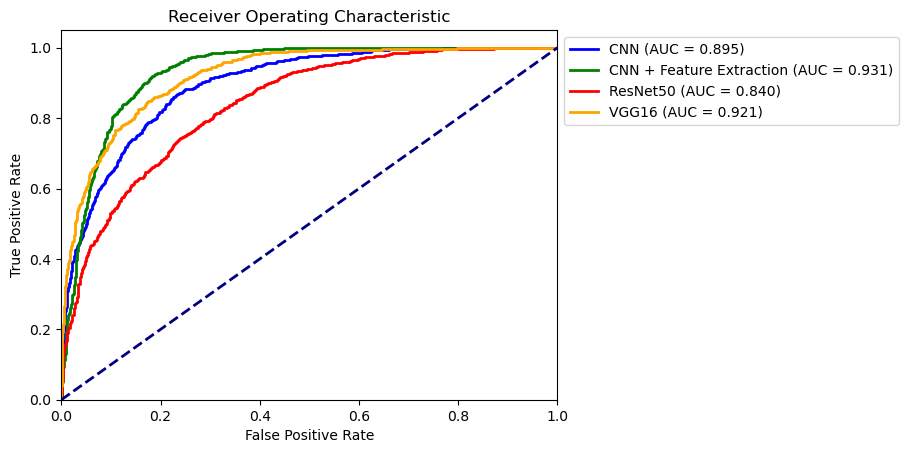

In [9]:
#ROC Curve

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label='CNN (AUC = %0.3f)' % roc_auc)
plt.plot(fpr1, tpr1, color='green', lw=2, label='CNN + Feature Extraction (AUC = %0.3f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='ResNet50 (AUC = %0.3f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='orange', lw=2, label='VGG16 (AUC = %0.3f)' % roc_auc3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

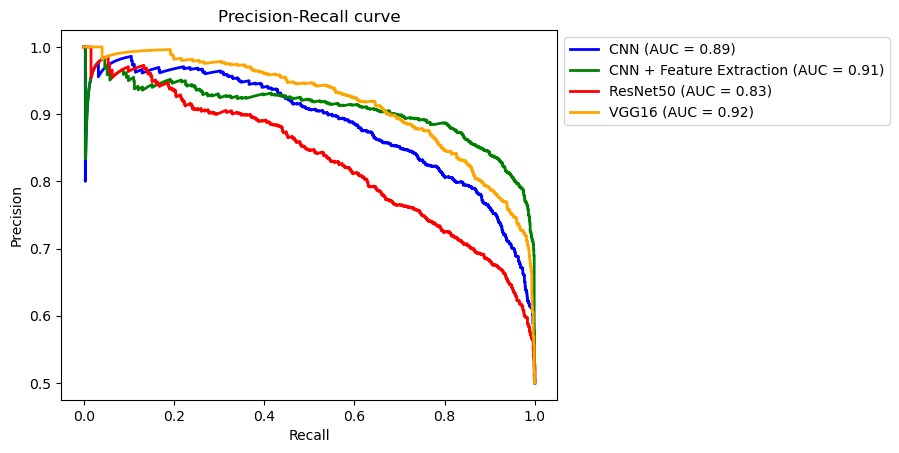

In [10]:
#Precision-Recall Curve

plt.figure()

plt.plot(recall0, precision0, color='blue', lw=2, label='CNN (AUC = %0.2f)' % auc_pr)
plt.plot(recall1, precision1, color='green', lw=2, label='CNN + Feature Extraction (AUC = %0.2f)' % auc_pr1)
plt.plot(recall2, precision2, color='red', lw=2, label='ResNet50 (AUC = %0.2f)' % auc_pr2)
plt.plot(recall3, precision3, color='orange', lw=2, label='VGG16 (AUC = %0.2f)' % auc_pr3)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


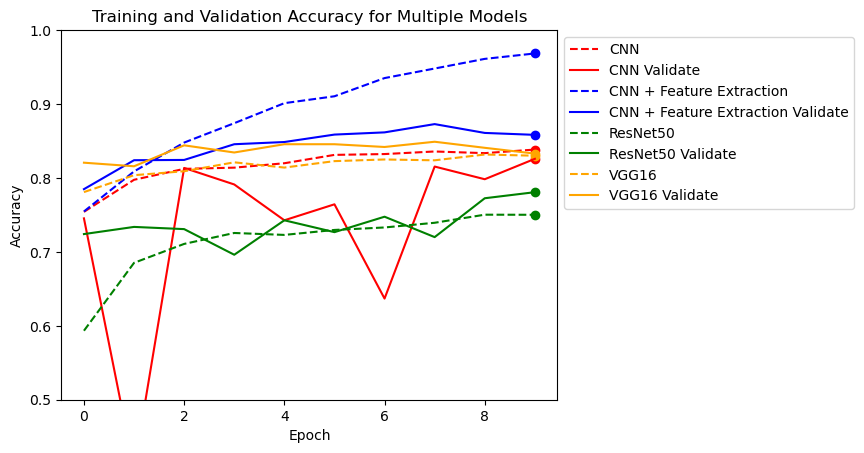

In [11]:
#Training and Validating Accuracy Graph
#End points are added in case epochs stop early

import matplotlib.pyplot as plt

#CNN
plt.plot(history.history['accuracy'], label='CNN', color='red', linestyle='--')
plt.plot(history.history['val_accuracy'], label='CNN Validate', color='red')
plt.scatter(len(history.history['accuracy']) - 1, history.history['accuracy'][-1], color='red')
plt.scatter(len(history.history['val_accuracy']) - 1, history.history['val_accuracy'][-1], color='red')

#Hybrid CNN
plt.plot(history1.history['accuracy'], label='CNN + Feature Extraction', color='blue', linestyle='--')
plt.plot(history1.history['val_accuracy'], label='CNN + Feature Extraction Validate', color='blue')
plt.scatter(len(history1.history['accuracy']) - 1, history1.history['accuracy'][-1], color='blue')
plt.scatter(len(history1.history['val_accuracy']) - 1, history1.history['val_accuracy'][-1], color='blue')

# ResNet50
plt.plot(history2.history['accuracy'], label='ResNet50', color='green', linestyle='--')
plt.plot(history2.history['val_accuracy'], label='ResNet50 Validate', color='green')
plt.scatter(len(history2.history['accuracy']) - 1, history2.history['accuracy'][-1], color='green')
plt.scatter(len(history2.history['val_accuracy']) - 1, history2.history['val_accuracy'][-1], color='green')

# VGG16
plt.plot(history3.history['accuracy'], label='VGG16', color='orange', linestyle='--')
plt.plot(history3.history['val_accuracy'], label='VGG16 Validate', color='orange')
plt.scatter(len(history3.history['accuracy']) - 1, history3.history['accuracy'][-1], color='orange')
plt.scatter(len(history3.history['val_accuracy']) - 1, history3.history['val_accuracy'][-1], color='orange')

# Set the y-axis limits for consistency
plt.axis(ymin=0.5, ymax=1)

plt.title('Training and Validation Accuracy for Multiple Models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


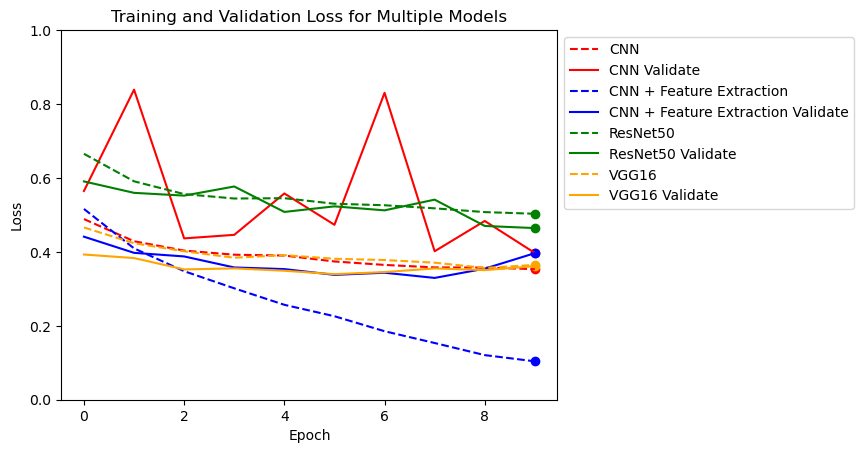

In [12]:
#Training and Validating Loss Graph
#End points are added in case epochs stop early

import matplotlib.pyplot as plt

plt.figure()

# CNN
plt.plot(history.history['loss'], label='CNN', color='red', linestyle='--')
plt.plot(history.history['val_loss'], label='CNN Validate', color='red')
plt.scatter(len(history.history['loss']) - 1, history.history['loss'][-1], color='red')
plt.scatter(len(history.history['val_loss']) - 1, history.history['val_loss'][-1], color='red')

# Hybrid Model
plt.plot(history1.history['loss'], label='CNN + Feature Extraction', color='blue', linestyle='--')
plt.plot(history1.history['val_loss'], label='CNN + Feature Extraction Validate', color='blue')
plt.scatter(len(history1.history['loss']) - 1, history1.history['loss'][-1], color='blue')
plt.scatter(len(history1.history['val_loss']) - 1, history1.history['val_loss'][-1], color='blue')

# ResNet50
plt.plot(history2.history['loss'], label='ResNet50', color='green', linestyle='--')
plt.plot(history2.history['val_loss'], label='ResNet50 Validate', color='green')
plt.scatter(len(history2.history['loss']) - 1, history2.history['loss'][-1], color='green')
plt.scatter(len(history2.history['val_loss']) - 1, history2.history['val_loss'][-1], color='green')

# Fourth model
plt.plot(history3.history['loss'], label='VGG16', color='orange', linestyle='--')
plt.plot(history3.history['val_loss'], label='VGG16 Validate', color='orange')
plt.scatter(len(history3.history['loss']) - 1, history3.history['loss'][-1], color='orange')
plt.scatter(len(history3.history['val_loss']) - 1, history3.history['val_loss'][-1], color='orange')

# Set the y-axis limits for consistency
plt.axis(ymin=0, ymax=1)

plt.title('Training and Validation Loss for Multiple Models')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [13]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
